# PDFs  at FPF

Need to obtain double differential cross section, $\frac{d^2\sigma(x,y,Q^2)}{dxdy}$

where x is Bjorken-x $\in \left[0,1\right]$, $Q^2$ is momentum transfer squared, and y is the fraction of energy transfered to the outgoing lepton with respect to incoming neutrino energy, i.e. , $ y = 1-E_l/E_{\nu}$. 

Want to bin events in a 3d space $x,y,Q^2$ (or $ E_{\nu})$ 

Ultimately, we will choose include nuclear effects, base PDF's, etc. but we will start with the simple case of scattering off free protons.

First generate csv of different x,y, $Q^2$ values.

Will start with a 10x10x10 grid with range 

$1{\rm GeV}^2< Q^2< {\rm TeV}^2$,

$0 < y < 1$,

and

$10^{-4}< x < 1 $

# Write $x,y, Q^2$ listings, for $\frac{d^2\sigma}{dxdy}$ to be computed in Yadism

In [1]:
import itertools 
import numpy as np
#n points in each variable --> n**3 evaluations
n = 10

#choose y,x,log10(Q^2) range. Linearly spaced y, logspaced  x and Q^2
y = np.linspace(0,1,n)
x = np.logspace(-4,0,n)
logQ2_lower = -4;logQ2_upper = 6;
Q2 = np.logspace(logQ2_lower,logQ2_upper,n) #in GeV^2

#combine all combinations into an array
A = [x , y , Q2]
M = list(itertools.product(*A))
LX = np.zeros(n**3);Y = np.zeros(n**3);LQ2 = np.zeros(n**3)
data = np.zeros(shape = (n**3,3))
data = [ [0]*3 for i in range(n**3)]
for ii,m in enumerate(M):
    data[ii][0] = np.log10(M[ii][0])
    data[ii][1] =          M[ii][1]
    data[ii][2] = np.log10(M[ii][2])
    
#save and write to xyQ2.csv
import csv  
header = ['Log10(x)','y','Log10(Q^2 / GeV^2)']
stringsave = 'xyQ2_2.csv'
with open(stringsave, 'w') as f:
    writer = csv.writer(f)
    # write the header
    writer.writerow(header)
    # write the data
    writer.writerows(data)

In [2]:
MAP_FL = {14: "nu", -14: "nub"}

# Load in $\frac{d^2\sigma}{dxdy}(x,y, Q^2) $, load in neutrino spectra, interpolate each for custom binning. Also a short script for experimental target details
Need to have d2sigma(x,y,Q2) generated from $\nu$FPF.

Need to have "Fluxes" folder from https://github.com/KlingFelix/FastNeutrinoFluxSimulation/tree/main/Fluxes 

In [3]:
import os
from decimal import Decimal
import matplotlib.pyplot as plt
import scipy
import pdb
import numpy as np
from scipy.integrate import nquad
from scipy.interpolate import interp1d
import scipy.spatial as ss
import time

import random
from scipy.interpolate import interpn
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#Define some constants 
G_fermi = 1.166e-5 
MW = 80.379
prefac_const = G_fermi**2 / (4 * np.pi)

#load input points and differential cross sections
with open('diff-xsec_charm-a1iso.txt') as f:
    lines = f.readlines()
    x_list = np.array([float(lines[ii+1].split()[0]) for ii in np.arange(len(lines)-1)])
    y_list = np.array([float(lines[ii+1].split()[1]) for ii in np.arange(len(lines)-1)])
    Q2_list_gev2 = np.array([float(lines[ii+1].split()[2]) for ii in np.arange(len(lines)-1)])
    
    #prefactor for previous definition of xsec. No longer used but keeping for posterity
    prefactor = 4 * prefac_const * 1 / (2 * x_list * (1 + (Q2_list_gev2 / MW**2))**2)
    
    #change prefactor to 1
    prefactor = 1
    xsecnu_invgev2 = prefactor * np.array([float(lines[ii+1].split()[3]) for ii in np.arange(len(lines)-1)])
    xsecnub_invgev2 = prefactor * np.array( [float(lines[ii+1].split()[4]) for ii in np.arange(len(lines)-1)])

#organize into 3D matrix (for interpolation)    
xu = np.unique(x_list);yu = np.unique(y_list);qu = np.unique(Q2_list_gev2);
dsigmanu_dxdy = np.zeros(shape=(10,10,10));dsigmanub_dxdy = np.zeros(shape=(10,10,10))
count = 0
for ix,x in enumerate(xu):
    for iy,y in enumerate(yu):
        for iq,q in enumerate(qu):
            dsigmanu_dxdy[ix,iy,iq] = xsecnu_invgev2[count]
            dsigmanub_dxdy[ix,iy,iq] = xsecnub_invgev2[count]
            count +=1    

#write interpolating function
#yadism outputs d2sigma/dx/dq2 * 1/4. Here I account for 1/4 factor
points = (xu,yu,qu)
def dsigmanudxdq2_interp_invgev2(x,y,q2):
#     prefactor = prefac_const * 1 / (x * (1 + (q2 / MW**2))**2)
    return interpn(points,dsigmanu_dxdy,(x,y,q2)) 

def dsigmanubdxdq2_interp_invgev2(x,y,q2):
    return interpn(points,dsigmanub_dxdy,(x,y,q2))   

#write dsigmadxdy = dsigmadxdq2 * dq2 / dy
def dsigmanudxdy_interp_invgev2(x,y,q2):
    E_nu = q2 / (2 * y * m_N * x)
    jacobian = 1 * (2 * E_nu * m_N * x)
    return dsigmanudxdq2_interp_invgev2(x,y,q2) * jacobian

def dsigmanubdxdy_interp_invgev2(x,y,q2):
    E_nu = q2 / (2 * y * m_N * x)
    jacobian = 1 * (2 * E_nu * m_N * x)
    return dsigmanubdxdq2_interp_invgev2(x,y,q2) * jacobian
    
#specify experiment {FASERv, FASERv2, FLArE10, FLArE100,AdvSND}
#gives neutrino flux (dN vs E) at experiment for neutrino with flavor {ve,vmu,vtau} = {12,14,16}
def dn_de(experiment,pid, raw = 0):
    if ('optimistic' in experiment) | ('nocuts' in experiment) | ('best' in experiment):
        experiment = experiment.split('_')[0]
    folder = os.path.join('Fluxes',experiment);L = os.listdir(folder)
    file = [f for f in L if '_'+str(pid) in f and 'CC' not in f];file = os.path.join(folder,file[0])
    with open(file) as f:
        lines=f.readlines()
        e_gev = np.array([float(lines[ii].split()[0]) for ii in np.arange(len(lines))])
        N_perbin = np.array([float(lines[ii].split()[1]) for ii in np.arange(len(lines))])
        
    #energies are evenly log10spaced. get dn_de by dividing by bin width
    width = e_gev * (e_gev[2]/e_gev[1] - 1)
    dnde_invgev = N_perbin / width
    if raw ==1:
        return e_gev, N_perbin
    else:
        return e_gev, dnde_invgev

#what is proton density and length of each experiment?
def experiment_nL(experiment):
    if ('optimistic' in experiment) | ('nocuts' in experiment) | ('best' in experiment):
        experiment = experiment.split('_')[0]
    experiments = ['FASERv', 'FASERv2', 'FLArE10', 'FLArE100','AdvSND']
#     print(experiment)
    index = experiments.index(experiment)
    Na = 6.02e23
    Z_Ar = 18;g_per_cm3_Ar = 1.4;MM_Ar = 39.9
    Z_W = 74;g_per_cm3_W = 19.3;MM_W = 183
    
    #density / Molar Mass * Avogardo * Z = protons / cm^3
    tungsten_proton_density = g_per_cm3_W / MM_W * Na * Z_W 
    LAr_proton_density = g_per_cm3_Ar / MM_Ar * Na * Z_Ar
    
    #density / Molar Mass * Avogardo * MolarMass = nucleons / cm^3
    tungsten_nucleon_density = g_per_cm3_W / MM_W * Na * MM_W 
    LAr_nucleon_density = g_per_cm3_Ar / MM_Ar * Na * MM_Ar
    
    #fasernu, SND are tungsten, Flare is liquid argon.
    proton_densities_percm3 = [tungsten_proton_density,tungsten_proton_density,LAr_proton_density,LAr_proton_density,tungsten_proton_density]
    nucleon_densities_percm3 = [tungsten_nucleon_density,tungsten_nucleon_density,LAr_nucleon_density,LAr_nucleon_density,tungsten_nucleon_density]
    
    #Experimental lengths in cm. (What is AdvSND length? I set to zero for now)
    lengths_cm = np.array([1,2,7,30,6])*100
    return nucleon_densities_percm3[index],lengths_cm[index]

# Calculate CC Event rate
With $x = \frac{Q^2}{2m_N (E_{\nu}-E_l)}$, $y = 1 - E_l/E_{\nu} = \frac{Q^2}{2m_N E_{\nu }x}$. 
where $m_N$ is the proton mass.

Total number of DIS events $N_{tot} = N_{\nu} \times L n_T \sigma$. Where $N_{\nu}$ is the number of incident neutrinos, $L$ is the length of the detector / target, $n_T$ is the target number density, and $\sigma$ is the 
neutrino-nucleon interaction cross section. For this first pass, we are treating the target as free protons with a number density determined by the mateiral (Tungsten or LAr).

Write $N_{\nu} = \int \frac{dN_{\nu}}{dE_{\nu}} dE_{\nu}$ 
and
$\sigma = \int \int \frac{d^2\sigma(x,y,Q^2)}{dxdy} dx dy$

Output from Yadism is (i.e. under xsec_nu column in diff_xsecs_a1.txt)

Update: Have properly included the prefactors from $xsec_{old}$ in $xsec_{new}$. So now output from diff_xsecs_a1_iso.txt is $xsec_{new}$

$$xsec_{old} = \frac{d^2\sigma}{dx dQ^2}\frac{1}{4}\left(\frac{G_{\rm F}^2}{4 \pi}\frac{1}{2 x (1+ Q^2 / m_W^2)^2}\right)^{-1} [{\rm GeV^{-8}}]$$
$$xsec_{new} = \frac{d^2\sigma}{dx dQ^2} [{\rm pb ~/~ GeV^2}]$$


Write the number of events per bin, normalized by target density and length, as

$$N_{\rm bin}/(n_T L) =\int_{E_{\nu}} \int_y \int_x \frac{dN_{\nu}}{dE_{\nu}}\frac{d^2\sigma(x,y,E_{\nu})}{dxdy}dE_{\nu} dx dy = \int_{E_{\nu}} \int_y \int_x g(x,E_{\nu},y) dE_{\nu} dx dy
\\
=\int_{E_{\nu}} \int_{Q^2} \int_x \frac{dN_{\nu}}{dE_{\nu}}\frac{d^2\sigma(x,E_{\nu},Q^2)}{dxdy} \frac{1}{2m_NE_{\nu}x}dE_{\nu} dx dQ^2 = \int_{E_{\nu}} \int_{Q^2} \int_x f(x,E_{\nu},Q^2) dE_{\nu} dx dQ^2
$$

where the second line follows from $y = \frac{Q^2}{2m_N E_{\nu }x}$, $dy = \frac{dQ^2}{2m_NE_{\nu}x}$.


We then do a MC integration per bin, depending on the choice of binning.

For bins in $x,E_{\nu},y$ write integrand as $g(x,E_{\nu},y) = \frac{dN_{\nu}}{dE_{\nu}}\frac{d^2\sigma(x,y,E_{\nu})}{dxdy} $


For bins in $x,E_{\nu},Q^2$ write integrand as $f(x,E_{\nu},Q^2) = \frac{dN_{\nu}}{dE_{\nu}}\frac{d^2\sigma(x,E_{\nu},Q^2)}{dxdy} \frac{1}{2m_NE_{\nu}x} = \frac{dN_{\nu}}{dE_{\nu}}\frac{d^2\sigma(x,E_{\nu},Q^2)}{dxdQ^2}  $

For MC integration, pick $N$ random points from bin on a uniform distribution, $(x_i, E_{\nu,i},y_i)$ so 

$$N_{\rm bin}\approx n_T~L \times \frac{V}{N}\sum_i^N~g(x_i, E_{\nu,i},y_i)$$ 

Where $V$ is the volume element of the bin.

# Now define function N_bin($x_{bin},E_{\nu,bin},y_{bin})$), the number of events in a particular bin. 
We currently bin in x, $E_{\nu}$, $Q^2$. Scroll down to N_bin_alt function
Also dependent on experiment, and neutrino flavor

# Alternate function which will bin events in $x,E_{\nu},Q^2$ (this is the main function we use with .txt file output)

In [4]:
#uses f(x,y,Enu) defined above. Used if you want bins in x,y,Q^2
from scipy.integrate import nquad
from scipy.interpolate import interp1d
import random
def N_bin_alt(x_bins,Enu_bins,Q2_bins,experiment = 'FASERv',pid=14,N = 1000000,total_xsec = 0,m_N = 0.938,check_points = 0):
    #check if antineutrino
    anti = 1 if pid < 0 else 0;
    
    #target mass and experiment. 0.938 for proton.
    invgev2_in_cm2 = 3.89e-28
    cm2_in_pb = 1e-36
    
    #get experimental geometry
    n,L = experiment_nL(experiment)

    #interpolate to get dn_de
    e_gev,dnde_invgev = dn_de(experiment,pid);
    dn_de_interp = interp1d(e_gev,dnde_invgev,fill_value = 0)

    #write g function for x, y, E_nu binning. 
    if anti ==0:
        def f(x,Enu,q2):
            y = q2/(2*mt*Enu*x)
#             print(Enu,y,x,q2)
            return dn_de_interp(Enu) * dsigmanudxdq2_interp_invgev2(x,y,q2)
    elif anti ==1:
        def f(x,Enu,q2):
            y = q2/(2*m_N*Enu*x)
            return dn_de_interp(Enu) * dsigmanubdxdq2_interp_invgev2(x,y,q2) 
    

    #MC Integration
    #volume of bin
#     volume = (x_bins[1]-x_bins[0]) * (Enu_bins[1] - Enu_bins[0]) * (Q2_bins[1] - Q2_bins[0])
    #volume of bin
    
    
    #generate random numbers in x,Enu,y 
    x_array = np.random.uniform(x_bins[0],x_bins[1],size = N)
    Enu_array = np.random.uniform(Enu_bins[0],Enu_bins[1],size = N)
    Q2_array = np.random.uniform(Q2_bins[0],Q2_bins[1],size = N)
    y_array = Q2_array / (2 * m_N * Enu_array * x_array)
    locs = np.where(y_array < 1)
    x_array = x_array[locs];Enu_array = Enu_array[locs];Q2_array = Q2_array[locs]
    if check_points == 1:
        return x_array,Enu_array,Q2_array,y_array[locs]
    acceptance = len(locs[0]) / N
#     print('Acceptance is: ',acceptance,'x,Q2 is:',x_bins[0],Q2_bins[0])
    
    #evaluate integrand at points
    integrand = f(x_array,Enu_array,Q2_array)
#     print('N/10^3 is ', sum(integrand) * volume / N * n * L * invgev2_in_cm2/1e3)
#     print('acc rate',len(locs[0]))
    xavg = np.mean(x_array);q2avg = np.mean(Q2_array);Enuavg = np.mean(Enu_array) 
    
    MCpoints = [x_array,Q2_array,Enu_array]
    V = 0;del V
    if len(locs[0]) <= 3:
#         print('tripped',locs)
        volume = 0
        locs = np.array([[1]])
    else:
        volume = ss.ConvexHull(np.transpose(MCpoints)).volume
#         volume = (x_bins[1]-x_bins[0]) * (Enu_bins[1] - Enu_bins[0]) * (Q2_bins[1] - Q2_bins[0])
#     print('Integrand,volulme,len(locs),n,L,cm2_in_pb,acceptance,N')
#     print(sum(integrand),volume,len(locs[0]),n,L,cm2_in_pb,acceptance,N)
#     print(sum(integrand)/len(locs[0]))
    return sum(integrand) * volume / len(locs[0]) * n * L * cm2_in_pb,acceptance,N,xavg,q2avg,Enuavg

In [6]:
#This Cell writes binned_events.txt for a chosen neutrino and experiment
#bins in x, q2, Enu
m_N = 0.938;mt = 0.938

x_edges = np.logspace(-4,0,30)
Q2_edges = np.array([4,10**1,10**2,10**3,10**4,10**5])
Enu_edges = np.logspace(np.log10(11.336355),np.log10(5698.274),2)

pid = 14
experiment = 'FASERv2'
save = 0;
MC_perbin = 1000000

###########################
if pid < 0:
    sigma = dsigmanubdxdq2_interp_invgev2
else:
    sigma = dsigmanudxdq2_interp_invgev2

if save == 1:
    stringsave = 'outdated_binned_events_%s_%s.txt' %(experiment,str(pid))
    myfile = open(stringsave,'w')

    myfile.write(
        f"{'x_lower':<15} {'x_upper':<15} {'x_avg':<15}"
        f"{'Q2_lower[GeV^2]':<20} {'Q2_upper[GeV^2]':<20} {'Q2_avg[GeV^2]':<20}"
        f"{'E_nu_lower[GeV]':<20} {'E_nu_upper[GeV]':<20} {'E_nu_avg[GeV]':<20}"
        f"{'d^sigma/dxdQ2(x_avg,Q2_avg,Enu_avg) / GeV^-2':<55}"
        f"{'N_events':<15} {'N_events_errs = Sqrt[N_events]':<35} {'MC_Samples'} \n"
    )

N_sum = 0
flag_1k = 0
#write all bins, including ones with no events
plot_all_bins = 1
for ix,x_lower in enumerate(x_edges[:-1]):
    for iq,q2_lower in enumerate(Q2_edges[:-1]):
        for ie,E_lower in enumerate(Enu_edges[:-1]):
#             print(ie)
            x_upper,q2_upper,E_upper = x_edges[ix+1],Q2_edges[iq+1],Enu_edges[ie+1]
            x_bin = [x_lower,x_upper];q2_bin = [q2_lower,q2_upper];Enu_bin = [E_lower,E_upper];
#             print('x:',x_bin,'| q:',q2_bin,'| Enu:',Enu_bin)
            
            N,acceptance,Nsamples,xavg,q2avg,Enuavg = N_bin_alt(x_bin,Enu_bin,q2_bin,pid = pid,experiment = experiment,N = MC_perbin)
            
            
            N_sum += np.nan_to_num(N)
            x_mid,q2_mid,Enu_mid = np.mean(x_bin),np.mean(q2_bin),np.mean(Enu_bin)
            y_mid = q2_mid / (2 * m_N * Enu_mid * x_mid)
            yavg = q2avg / (2 * m_N * Enuavg * xavg)

            if ((np.nan_to_num(N)>0) | (plot_all_bins==1)):
                if np.nan_to_num(yavg,nan = 2) >1:
                    dsigma_mid = 0
                else:
#                     print(xavg,yavg,q2avg)
                    dsigma_mid = sigma(xavg,yavg,q2avg)
                if np.nan_to_num(N) > 1e3:
                    flag_1k += 1
#                 
                if save == 1:
                    if ( (np.isnan(N) | (N == 0 ) ) ) :
                        N = np.nan_to_num(N,nan = 0)
                        # xavg = np.mean(x_bin);q2avg = np.mean(q2_bin);Enuavg = np.mean(Enu_bin);dsigma_mid = np.nan
                        myfile.write(
                            f"{format(x_lower, '.6e'):<15} {format(x_upper, '.6e'):<15} {format(xavg, '.6e'):<15}"
                            f"{format(q2_lower, '.6e'):<20} {format(q2_upper, '.6e'):<20} {format(q2avg, '.6e'):<20}"
                            f"{format(E_lower, '.6e'):<20} {format(E_upper, '.6e'):<20} {format(Enuavg, '.6e'):<20}"
                            f"{format(float(dsigma_mid), '.6e'):<55}"
                            f"{format(float(np.nan_to_num(N)), '.6e'):<15} {format(float(np.sqrt(np.nan_to_num(N))), '.6e'):<35}"
                            f"{format(float(np.nan_to_num(acceptance)) * Nsamples, '.6e')} \n"
                        )
if save == 1:
    myfile.close()
print(N_sum)
#function to write summary at the top
def line_prepender(filename, line):
    with open(filename, 'r+') as f:
        content = f.read()
        f.seek(0, 0)
        f.write(line.rstrip('\r\n') + '\n' + content)
        
n,L = experiment_nL(experiment)

if save == 1:
    summary_line = 'Experiment = %s | Neutrino = %s | Exp. Target density (nucleons / cm3) = 10^(%0.1f) | Exp. Target Length = %0.0f cm | Total Events = %0.1f'  %(experiment, str(pid),np.log10(n),L,N_sum)      
    line_prepender(stringsave,summary_line)
print(flag_1k)

27869.310305963703
12


# Now for systematic uncertainties

Now for systematic uncertainties

Generate events in dataset $D_0 \in (E_l,\theta,E_H)$ space. Calculate variables in ($x,E_{\nu},Q^2$) space so $D_0\in  (E_l,\theta,E_H) ~{\rm or}~ (x,E_{\nu},Q^2)$. Now have list of kinematic variables and can do event binning

In other words, follow:
1) Generate N events in $100 ~{\rm GeV} < E_l < E_{\nu, {\rm max}},~~ 0 < \theta < \tan^{-1}(0.5),~~ 100 ~{\rm GeV} < E_{H} < E_{\nu, {\rm max}}$

2) For each event $n \in N$, calculate $x,Q^2,E_{\nu} $ and $y$. Cut out events with $y > 1$

3) Loop through $x,Q^2,E_{\nu}$ bins, find $n \in N$ such that $x,Q^2,E_{\nu}$ is in the bin and integrate with these data points. This is $N_0$

4) Now repeat by smearing $D_0$ according to uncertainties. $E_l$ has uniform(?) uncertainty 30%, $\theta$ has gaussian of width 1 mrad, $E_H$ has 30-50% (say 50 for now). This is $D_1$, repeat steps 1-3 to produce $N_1$

5) Produce $M$ datasets, (up to $D_{M-1}$), to produce $M$ different event rates per bin. Take standard deviation to get uncertainty

In [7]:
def locsinside(Bin,Array):
    locs = np.where((Array <= Bin[1]) & (Array >= Bin[0]))
    return locs

#returns threshold of expreriment 
def thresholds(experiment,neutrino):
    print('Flare only valid for muon neutrinos')
    if (experiment == 'FASERv2') | (experiment =='FASERv') | (experiment == 'FASERv2_optimistic') | (experiment =='FASERv_optimistic')| (experiment =='FASERv_best'):
        #treat minimum as same for lepton, max is maximum of neutrino energy
        EH_min = 100;EH_max = 5698
        theta_min = 0;theta_max = np.arctan(0.5)
        El_min = 100;El_max = 5698
    elif experiment =='FASERv2_nocuts':
        EH_min = 0;EH_max = 5698
        theta_min = 0;theta_max = np.pi
        El_min = 0;El_max = 5698
    elif experiment =='FLArE10':
        if np.abs(neutrino) == 14:#muon
            El_min = 10e-3;El_max = 2;
            theta_min = 0;theta_max = 0.4
            EH_min = 10e-3;EH_max = 6e3
        elif np.abs(neutrino) == 12:#electron
            El_min = 10e-3;El_max = 1e3
            theta_min = 0;theta_max = 0.5
            EH_min = 10e-3;EH_max = 6e3
    elif experiment =='AdvSND':
        EH_min = 20;EH_max = 6e3
        theta_min = 0;theta_max = 0.15
        El_min = 20;El_max = 6e3
            
    
    return EH_min,EH_max,theta_min,theta_max,El_min,El_max


def N_bin_alt_sys(x_bins,Enu_bins,Q2_bins,x_array_in,Enu_array_in,Q2_array_in,experiment = 'FASERv',pid=14,total_xsec = 0,m_N = 0.938,check_points = 0):
    #check if antineutrino
    anti = 1 if pid < 0 else 0;
    m_N = 0.938;mt = 0.938;
    
    #target mass and experiment. 0.938 for proton.
    invgev2_in_cm2 = 3.89e-28
    cm2_in_pb = 1e-36
    
    #get experimental geometry
    n,L = experiment_nL(experiment)

    #interpolate to get dn_de
    e_gev,dnde_invgev = dn_de(experiment,pid);
    dn_de_interp = interp1d(e_gev,dnde_invgev,fill_value = 0)

    #write g function for x, y, E_nu binning. 
    if anti ==0:
        def f(x,Enu,q2):
            y = q2/(2*mt*Enu*x)
#             print(Enu,y,x,q2)
            return dn_de_interp(Enu) * dsigmanudxdq2_interp_invgev2(x,y,q2)
    elif anti ==1:
        def f(x,Enu,q2):
            y = q2/(2*m_N*Enu*x)
            return dn_de_interp(Enu) * dsigmanubdxdq2_interp_invgev2(x,y,q2) 
    

    #MC Integration
    
    #generate random numbers in x,Enu,y 
    xlocs = locsinside(x_bins,x_array_in);Qlocs = locsinside(Q2_bins,Q2_array_in);Enulocs = locsinside(Enu_bins,Enu_array_in)
    locs = list(set(xlocs[0]) & set(Qlocs[0]) & set(Enulocs[0]))
    x_array = x_array_in[locs];Q2_array = Q2_array_in[locs];Enu_array = Enu_array_in[locs];
    if check_points ==1:
        return x_array,Q2_array,Enu_array
    if len(locs)>0:
#         pdb.set_trace()
        pass
    
    
    #volume of bin
    MCpoints = [x_array,Q2_array,Enu_array]
    V = 0;del V
    if len(locs) <= 3:
        V = 0
        locs = np.array([1])
    else:
        V = ss.ConvexHull(np.transpose(MCpoints)).volume
#         print(V,experiment)
#     print(len(locs),len(Q2_array_in))
    acceptance = len(locs) / len(Q2_array_in)
    
    
#     print('Acceptance is: ',acceptance)
    
    #evaluate integrand at points
    integrand = f(x_array,Enu_array,Q2_array)
    xavg = np.mean(x_array);q2avg = np.mean(Q2_array);Enuavg = np.mean(Enu_array) 
#     print(sum(integrand),V,len(locs),n,L,cm2_in_pb,acceptance,N)
#     print(sum(integrand)/len(locs))
    
    return sum(integrand) * V / len(locs) * n * L * cm2_in_pb,acceptance,len(locs),xavg,q2avg,Enuavg

# Here I check space of each method(debug)

In [8]:
MC_perbin = 1000000
# plt.figure(figsize = (16,8));plt.yscale('log');plt.xscale('log')
experiment = 'FASERv2'
neutrino = 14;pid = neutrino;mt = 0.938;m_N = mt
#pick bon
x_bin = [0.72790,1];q2_bin = [100,1000];Enu_bin = [11,5698]

#do traditional search

#This step gets the points for the traditional search, sampling over x, Q , y
x0,Enu_array0,Q0,y_array = N_bin_alt(x_bin,Enu_bin,q2_bin,pid = pid,experiment = experiment,N = MC_perbin,check_points = 1)
# X,Q = np.meshgrid(x0,Q0)
# z = dsigmanudxdq2_interp_invgev2(X,0.5,Q)

print('#################')
#This step calculates N0 given the traditional method
N0,_,_,x0avg,q0avg,_ = N_bin_alt(x_bin,Enu_bin,q2_bin,pid = pid,experiment = experiment,N = MC_perbin,check_points = 0)
print('#################')

# #plot the average point, not weighted by number
# plt.plot(x0avg,q0avg,'k*',markersize = 20,label = 'Average0')
# #plot all the points
# plt.scatter(x0,Q0,label = 'raw')    

########################################################
#new method

EH_min,EH_max,theta_min,theta_max,El_min,El_max = thresholds(experiment,pid)

EH_min,El_min = 2,2
#Get observables
El_array = np.random.uniform(low = El_min,high = El_max,size = MC_perbin);El_array_0 = np.copy(El_array)
EH_array = np.random.uniform(low = EH_min,high = EH_max,size = MC_perbin);EH_array_0 = np.copy(EH_array)

theta_max_capped = np.minimum(theta_max,np.nan_to_num(2*np.arcsin(np.sqrt(2*m_N*EH_array_0 / (4*El_array_0 * (EH_array_0 + El_array_0) ))),nan = np.inf))
theta_array = np.random.uniform(low = theta_min,high = theta_max_capped,size = MC_perbin);theta_array_0 = np.copy(theta_array)


########################################################3
#get observables
Enu_array = EH_array + El_array
Q2_array = 4*Enu_array*El_array*np.sin(theta_array/2)**2
x_array = Q2_array / (2 * m_N * (Enu_array - El_array))
y_array = Q2_array / (2 * m_N * Enu_array * x_array)

#make cuts
locs = np.where((y_array > 0 ) & (y_array < 1) & (x_array > 0) & (x_array < 1) & (Enu_array > 0) & (Enu_array < El_max) & (Q2_array > 4))
print('Fraction of points within bounds:' ,len(locs[0])/MC_perbin ,'and number of points is', len(locs[0]))
Enu_cut = Enu_array[locs]
x_cut = x_array[locs]
Q2_cut = Q2_array[locs]

#calculate event rate given my x array and Enu array and Q array
print('#################')
N1,acceptance,Nsamples,x1avg,q1avg,Enuavg = N_bin_alt_sys(x_bin,Enu_bin,q2_bin,x_cut,Enu_cut,Q2_cut,pid = pid,experiment = experiment)
print('#################')
# plt.plot(x1avg,q1avg,'y*',markersize = 20,label = 'Average1')

#calculate raw points for this method
x,q,Enu1 = N_bin_alt_sys(x_bin,Enu_bin,q2_bin,x_cut,Enu_cut,Q2_cut,pid = pid,experiment = experiment,check_points = 1)
#plot
# plt.scatter(x,q,label = 'energy')

# plt.rcParams["font.family"] = "Times New Roman";plt.rcParams["font.size"] = 20
print('N0,N1,N0/N1 = ',N0,N1,N0/N1)
print('(x0,q0),(x1,q1),average:',x0avg,q0avg,x1avg,q1avg)

# plt.legend(fontsize = 20,loc = 'upper right')
# #plot histograms of points
# fig,(ax1,ax2) = plt.subplots(1,2,figsize = (16,8))

# #plot histogram for each method, where are the x,q points?
# ax1.hist2d(x0,Q0,bins= 7);#ax1.set_xscale('log');ax1.set_yscale('log')
# ax2.hist2d(x,q,bins = 7);#ax2.set_xscale('log');ax2.set_yscale('log')

#plot histogram of energy for each method, where are energy bins?
# plt.figure(figsize = (16,8))
# R0 = plt.hist(Enu_array0,density = True,alpha = 0.5);R1 = plt.hist(Enu1,bins = R0[1],density = True,alpha = 0.5);

# yratio = R0[0] / R1[0]
e_array = np.linspace(15,5698,100)
e_gev,dnde_invgev = dn_de(experiment,pid);
dn_de_interp = interp1d(e_gev,dnde_invgev,fill_value = 0)
y = dn_de_interp(e_array)
# plt.figure(figsize = (16,8))
# plt.plot(e_array,y/np.max(y)/10000)
# plt.yscale('log')
# plt.figure(figsize = (16,8))
# delta = R0[0][1]-R0[0][0]
# plt.step(R0[1][:-1],R0[0]/R1[0],where = 'pre')
# # plt.plot(R0[0][:-1]+delta/2,)

#################
#################
Flare only valid for muon neutrinos
Fraction of points within bounds: 0.475364 and number of points is 475364
#################
#################
N0,N1,N0/N1 =  1037.1630020939651 1043.8953280136316 0.9935507653507014
(x0,q0),(x1,q1),average: 0.8643151197012596 542.3420108279495 0.854217622563164 544.299486311384


Now do calculation according to: 

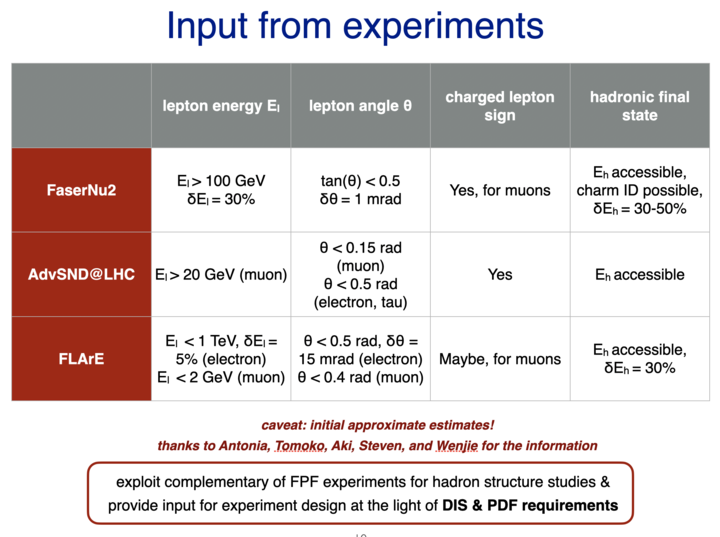

In [9]:
#returns deltheta,delEl,delEh
def delta_exp(experiment,neutrino):
    if (experiment == 'FASERv2') | (experiment =='FASERv') | (experiment =='FASERv2_nocuts'):# | (experiment == 'FASERv2_optimistic'):
        deltheta,delEl,delEh = 1e-3,0.3,0.5
    elif (experiment == 'FASERv2_optimistic') | (experiment =='FASERv_optimistic'):
        deltheta,delEl,delEh = 1e-3/2 , 0.3/2 , 0.5/2
    elif experiment =='FASERv2_best':
        deltheta,delEl,delEh = 0 , 0 , 0
    elif experiment == 'FLArE10':
        if np.abs(neutrino) == 14:#muon
            deltheta,delEl,delEh = 15e-3,0.05,0.3
        elif np.abs(neutrino) == 12:#electron
            deltheta,delEl,delEh = 15e-3,0.05,0.3
    elif experiment == 'AdvSND':
        deltheta,delEl,delEh = 1e-3,0.1,0.1
    return deltheta,delEl,delEh


#function to go through and save to .txt in same fashion. Have D_
def file_saver(D_array,xavg_array,Q2avg_array,Enuavg_array,sample_array,x_edges,Q2_edges,Enu_edges,stringsave,pid):
    plot_all_bins = 1
    if pid < 0:
        sigma = dsigmanubdxdq2_interp_invgev2
    else:
        sigma = dsigmanudxdq2_interp_invgev2
    
    #loop over
    myfile = open(stringsave,'w')
    m_N = 0.938
    N_sum = 0
    
    myfile.write(
        f"{'x_lower':<15} {'x_upper':<15} {'x_avg':<15}"
        f"{'Q2_lower[GeV^2]':<20} {'Q2_upper[GeV^2]':<20} {'Q2_avg[GeV^2]':<20}"
        f"{'E_nu_lower[GeV]':<20} {'E_nu_upper[GeV]':<20} {'E_nu_avg[GeV]':<20}"
        f"{'d^sigma/dxdQ2(x_avg,Q2_avg,Enu_avg) / GeV^-2':<55}"
        f"{'N_events':<15} {'N_events_errs = Sqrt[N_events]':<35} {'N_sys_errs':<20}"
        f"{'MC_Samples'} \n"
    )
    for ix,x_lower in enumerate(x_edges[:-1]):
            for iq,q2_lower in enumerate(Q2_edges[:-1]):
                for ie,E_lower in enumerate(Enu_edges[:-1]):
                    #get upper bins values
                    x_upper,q2_upper,E_upper = x_edges[ix+1],Q2_edges[iq+1],Enu_edges[ie+1]
                    
                    #calculate relevant quantities
                    #first calculate averages along axis
                    xavg = np.nanmean(xavg_array[ix,iq,ie,1:])
                    # import ipdb; ipdb.set_trace()
                    q2avg = np.nanmean(Q2avg_array[ix,iq,ie,1:])
                    Enuavg = np.nanmean(Enuavg_array[ix,iq,ie,1:])
                    yavg = q2avg / (2 * m_N * Enuavg * xavg)
                    
                    
                    if yavg >1 or np.isnan(yavg):
                        dsigma_mid = np.nan
                    else:
                        try:
                            dsigma_mid = sigma(xavg,yavg,q2avg)
                        except:
                            print(xavg,yavg,q2avg)
                            raise('error')
                    N_here = np.mean(D_array[ix,iq,ie,1:])
                    sys_error = np.std(D_array[ix,iq,ie,1:])
                    
                    N_sum += N_here
                    Nsamples = np.sum(sample_array[ix,iq,ie,1:])

                    #uncertainty = std() / loop = sqrt(average)
#                     MC_error = np.std(D_array[ix,iq,ie,0,:]) / (len(D_array[ix,iq,ie,0,:])) 

                    #not really MC error,statistical error
                    MC_error = np.sqrt(N_here)
#                     print(MC_error,)
                    
                    #save
                    if ((np.nan_to_num(N_here)>0) | (plot_all_bins==1)):
                
                        ### Remove all `nan`s from the entry
                        # if not np.isnan(xavg) and not np.isnan(q2avg) and not np.isnan(Enuavg):                     
                        myfile.write(
                            f"{format(x_lower, '.6e'):<15} {format(x_upper, '.6e'):<15} {format(xavg, '.6e'):<15}"
                            f"{format(q2_lower, '.6e'):<20} {format(q2_upper, '.6e'):<20} {format(q2avg, '.6e'):<20}"
                            f"{format(E_lower, '.6e'):<20} {format(E_upper, '.6e'):<20} {format(Enuavg, '.6e'):<20}"
                            f"{format(float(dsigma_mid), '.6e'):<55}"
                            f"{format(float(np.nan_to_num(N_here)), '.6e'):<15} {format(float(MC_error), '.6e'):<35}"
                            f"{format(float(sys_error), '.6'):<20}"
                            f"{format(float(np.nan_to_num(acceptance)) * Nsamples, '.6e')} \n"
                        )
                    else:
                        print('here')
    return N_sum


def line_prepender2(filename, line):
    with open(filename, 'r+') as f:
        content = f.read()
        f.seek(0, 0)
        f.write(line.rstrip('\r\n') + '\n' + content)
#finds out what to name D_array
def file_namer(experiment,neutrino,seed):
    A = os.listdir()
    count = 0
    for item in A:
        if 'D_array_%s_%s' %(experiment,neutrino) in item:
            count+=1
    stringsave = 'D_array_%s_%s_%s.npz' %(experiment,str(neutrino),str(seed))
    return stringsave


from datetime import datetime

# datetime object containing current date and time



#metaparameter, N
#####first write for D_0######
#metaparameters, N

def get_D(M,N,seed,experiment,pid,save = 1,check_points = 0,smear_corr = ''):
# def get_D(M,N,seed,pid,save = 0):
##########################################
    np.random.seed(seed = seed)
    m_N = 0.938;mt = 0.938;flag_1k = 0

    #get extrema limits for observables
    EH_min,EH_max,theta_min,theta_max,El_min,El_max = thresholds(experiment,pid)

    x_edges = np.logspace(-4,0,30)
    Q2_edges = np.array([4,10**1,10**2,10**3,10**4,10**5]);
    Enu_edges = np.logspace(np.log10(11.336355),np.log10(5698),2)
    
    ##################Initialize###################
    D_array = np.zeros((len(x_edges)-1 , len(Q2_edges - 1), len(Enu_edges) - 1 , M))
    xavg_array = np.zeros((len(x_edges)-1 , len(Q2_edges - 1), len(Enu_edges) - 1 , M))
    Q2avg_array = np.zeros((len(x_edges)-1 , len(Q2_edges - 1), len(Enu_edges) - 1 , M))
    Enuavg_array = np.zeros((len(x_edges)-1 , len(Q2_edges - 1), len(Enu_edges) - 1 , M))
    sample_array = np.zeros((len(x_edges)-1 , len(Q2_edges - 1), len(Enu_edges) - 1 , M))
    ##############SmearingParameters##############
    #Del_El and del_Eh are fractional uncertainties of energy. i.e. delta_EL = El * del_El
    del_theta,del_El,del_EH = delta_exp(experiment,pid)

    #Can now choose whether these uncertainties are treated as uniform widths, or gaussian widths
    distributions = ['gaussian','gaussian','gaussian']
    delta_array = [del_theta,del_El,del_EH]
    ###############################################

    for im,m in enumerate(np.arange(M)):
        print(experiment)

        ########################################################
        #generate N randomly generated points. This is D_0
        if im == 0:
            El_array = np.random.uniform(low = El_min,high = El_max,size = N);El_array_0 = np.copy(El_array)
            
            #cap Eh based on El
            EH_array = np.random.uniform(low = EH_min,high = EH_max,size = N);EH_array_0 = np.copy(EH_array)
            
            #here I write x : x = (4El(Eh+El)sin^2(theta/2) / (2 mN EH)) --> theta < 2 sqrt( 2 mN EH / (4 El (Eh + El)))
            theta_max_capped = np.minimum(theta_max,np.nan_to_num(2*np.arcsin(np.sqrt(2*m_N*EH_array_0 / (4*El_array_0 * (EH_array_0 + El_array_0) ))),nan=np.inf)) 
            theta_array = np.random.uniform(low = theta_min,high = theta_max_capped,size = N);theta_array_0 = np.copy(theta_array)
        ########################################################

        ########################################################
        #smearing
#         print(im)
        if im < 0 :
            #no smearing
            pass
        elif smear_corr == '':
            #smear
            print(im,'smearing')
            now = datetime.now()
            dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
            print("date and time =", dt_string)
            for (iid,dist),delta in zip(enumerate(distributions),delta_array):
                if dist == 'gaussian':
                    if iid == 0:
                        theta_array = np.random.normal(loc = theta_array_0, scale = delta)
                    elif iid ==1:
                        El_array = np.random.normal(loc = El_array_0,scale = delta * El_array_0)
                    elif iid ==2:
                        EH_array = np.random.normal(loc = EH_array_0,scale = delta * EH_array_0)
        elif smear_corr != '':
            #delta_array = [del_theta,del_El,del_EH]
            stringarray = ['theta','Elepton','Ehadron'];index = stringarray.index(smear_corr);delta = delta_array[index]
            if smear_corr == 'theta':
                print('Smearing ',smear_corr,':theta')
                theta_array = np.random.uniform(low = theta_array_0 - delta / 2, high = theta_array_0 + delta/2)
            elif smear_corr =='Elepton':
                El_array = np.random.uniform(low = El_array_0 * (1 - delta / 2) , high = El_array_0 * (1 + delta / 2))
                print('Smearing ',smear_corr,':Elepton')
            elif smear_corr =='Ehadron':
                EH_array = np.random.uniform(low = EH_array_0 * (1 - delta / 2) , high = EH_array_0 * (1 + delta / 2))
                print('Smearing ',smear_corr,':Ehadron')


        #for each event calculate x,y,Q^2,E_nu. Cut out events with y<0, y>0, Q^2<4, E_nu > 5298 or <0.
        Enu_array = EH_array + El_array
        Q2_array = 4*Enu_array*El_array*np.sin(theta_array/2)**2
        x_array = Q2_array / (2 * m_N * (Enu_array - El_array))
        y_array = Q2_array / (2 * m_N * Enu_array * x_array)
        ########################################################

        #now cut
        Enu_max = 6e3
        locs = np.where((y_array > 0 ) & (y_array < 1) & (x_array > 0) & (x_array < 1) & (Enu_array > 0) & (Enu_array < Enu_max) & (Q2_array > 4))
        print('Fraction of points within bounds:' ,len(locs[0])/N ,'and number of points is', len(locs[0]))
        print('Fraction of points lost under,over energy:',np.sum(Enu_array<0)/N,np.sum(Enu_array > Enu_max)/N)
        print('Fraction of points lost due to small Q',np.sum(Q2_array<4)/N)
        print('Fraction of points lost due to large y',np.sum(y_array>1)/N)
        print('fraction of points lost due to large x',np.sum(x_array>1)/N)
        Enu_cut = Enu_array[locs]
        x_cut = x_array[locs]
        Q2_cut = Q2_array[locs]
        if check_points == 1:
            y_cut = Q2_cut / (2 * m_N * Enu_cut * x_cut)
            return Enu_cut,x_cut,Q2_cut,y_cut
#         del Q2_array,Enu_array,x_array,El_array,El_array_0,EH_array,EH_array_0,theta_array,theta_array_0

        ########################################################

        #Loop through chosen bins and integrate. Use convex hull and alter N_alt_bin --> needs to intake x,Q^2,Enu array.
        stringsave = 'binned_sysevents_%s_%s.txt' %(experiment,str(pid))
#         myfile = open(stringsave,'w')
        if pid < 0:
            sigma = dsigmanubdxdq2_interp_invgev2
        else:
            sigma = dsigmanudxdq2_interp_invgev2

        N_sum = 0
        plot_all_bins = 0
        for ix,x_lower in enumerate(x_edges[:-1]):
            for iq,q2_lower in enumerate(Q2_edges[:-1]):
                for ie,E_lower in enumerate(Enu_edges[:-1]):
                    #get upper of xbins
                    x_upper,q2_upper,E_upper = x_edges[ix+1],Q2_edges[iq+1],Enu_edges[ie+1]

                    #form xbins
                    x_bin = [x_lower,x_upper];q2_bin = [q2_lower,q2_upper];Enu_bin = [E_lower,E_upper];

                    #calculate from function
                    t1 = time.time()
                    N_here,acceptance,Nsamples,xavg,q2avg,Enuavg = N_bin_alt_sys(x_bin,Enu_bin,q2_bin,x_cut,Enu_cut,Q2_cut,pid = pid,experiment = experiment)
#                     if acceptance > 0:x_bins,Enu_bins,Q2_bins,x_array_in,Enu_array_in,Q2_array_in,experiment = 'FASERv',pid=14,total_xsec = 0,m_N = 0.938,check_points = 0
#                         print(acceptance,Nsamples)
#                         pdb.set_trace()
                    t2 = time.time()
    #                 print('Time to complete per loop:',t2-t1)
                    D_array[ix,iq,ie,im] = N_here
                    xavg_array[ix,iq,ie,im] = xavg
                    Q2avg_array[ix,iq,ie,im] = q2avg
                    Enuavg_array[ix,iq,ie,im] = Enuavg
#                     pdb.set_trace()
                    sample_array[ix,iq,ie,im] = Nsamples


                    #sum to get total event
                    N_sum += np.nan_to_num(N_here)

                    #get avg parameters and middle value
                    x_mid,q2_mid,Enu_mid = np.mean(x_bin),np.mean(q2_bin),np.mean(Enu_bin)
                    y_mid = q2_mid / (2 * m_N * Enu_mid * x_mid)
                    yavg = q2avg / (2 * m_N * Enuavg * xavg)
        print('Total Events in this step:',np.sum(D_array[:,:,:,im]))


    return D_array,xavg_array,Q2avg_array,Enuavg_array,sample_array,x_edges,Q2_edges,Enu_edges

To check smear. Here is where the main loop runs

In [13]:
#mutli loop 182258.00086330783
#get_D(M,N,seed,experiment,pid,save = 0)

# experiment_array = ['FASERv','FASERv2','FASERv2_optimistic']#,'FLArE10','AdvSND']
experiment_array = ['FASERv2']
# experiment_array = ['FLArE10','FASERv', 'FASERv2', 'FASERv2_nocuts', 'FASERv2_optimistic']
neutrino_array = [14,-14]
M = 10;seed = 1
N = 100000

# s_c = ''
# s_c = 'Elepton';seed = np.random.randint(10000)
# s_c = 'Ehadron';seed = np.random.randint(10000)
s_c = 'theta';seed = np.random.randint(10000)

for neutrino in neutrino_array:
    pid = neutrino
    total = np.zeros(M)
    average = np.zeros(M)
    for experiment in experiment_array:

        D_array,xavg_array,Q2avg_array,Enuavg_array,sample_array,x_edges,Q2_edges,Enu_edges = get_D(M,N,seed,experiment,neutrino,smear_corr = s_c)
        print(np.sum(D_array))

        #save
        save = 1
        if save == 1:
            if experiment not in os.listdir():
                os.makedirs(experiment)
            n,L = experiment_nL(experiment)
            EH_min,EH_max,theta_min,theta_max,El_min,El_max = thresholds(experiment,neutrino)

            del_theta,del_El,del_EH = delta_exp(experiment,neutrino)
            if s_c == '':
                stringsave = '%s/nan_binned_sysevents_%s_%s_charm.txt' %(experiment,experiment,MAP_FL[pid])
            else:
                stringsave = '%s/nan_smear_%s_%s_%s_charm.txt' %(experiment,experiment,MAP_FL[pid],s_c)
            
            print(stringsave)

            N_sum = file_saver(D_array,xavg_array,Q2avg_array,Enuavg_array,sample_array,x_edges,Q2_edges,Enu_edges,stringsave,pid)
            print(N_sum)
            summary_line = 'Experiment = %s | Neutrino = %s | Exp. Target density (nucleons / cm3) = 10^(%0.1f) | Exp. Target Length = %0.0f cm | Total Events = %0.1f |\
            del_theta = %0.1f mrad, theta_max = %0.1f mrad |\
            del_Elepton = %0.1f %% , Elepton_min = %0.2f GeV, Elepton_max = %0.2f GeV|\
            del_Ehadron = %0.1f %%, Ehadron_min = %0.2f GeV GeV, Ehadron_max = %0.2f GeV'\
            %(experiment, str(pid),np.log10(n),L,N_sum,del_theta*1e3,theta_max*1e3,del_El*1e2,El_min,El_max,del_EH*1e2,EH_min,EH_max) 

            line_prepender2(stringsave,summary_line)
            #             print(flag_1k)
            nump_save = file_namer(experiment,pid,seed)
#             np.savez(nump_save,D_array)

Flare only valid for muon neutrinos
FASERv2
Smearing  theta :theta
Fraction of points within bounds: 0.5091 and number of points is 50910
Fraction of points lost under,over energy: 0.0 0.46462
Fraction of points lost due to small Q 0.03347
Fraction of points lost due to large y 0.0
fraction of points lost due to large x 0.00773
Total Events in this step: 16307.143759552835
FASERv2
Smearing  theta :theta
Fraction of points within bounds: 0.50931 and number of points is 50931
Fraction of points lost under,over energy: 0.0 0.46462
Fraction of points lost due to small Q 0.03362
Fraction of points lost due to large y 0.0
fraction of points lost due to large x 0.00797
Total Events in this step: 16260.447258841199
FASERv2
Smearing  theta :theta
Fraction of points within bounds: 0.50903 and number of points is 50903
Fraction of points lost under,over energy: 0.0 0.46462
Fraction of points lost due to small Q 0.03372
Fraction of points lost due to large y 0.0
fraction of points lost due to larg

/tmp/ipykernel_74002/781908988.py:48: RuntimeWarning: Mean of empty slice
  xavg = np.nanmean(xavg_array[ix,iq,ie,1:])
/tmp/ipykernel_74002/781908988.py:50: RuntimeWarning: Mean of empty slice
  q2avg = np.nanmean(Q2avg_array[ix,iq,ie,1:])
/tmp/ipykernel_74002/781908988.py:51: RuntimeWarning: Mean of empty slice
  Enuavg = np.nanmean(Enuavg_array[ix,iq,ie,1:])


Total Events in this step: 4345.202262855432
FASERv2
Smearing  theta :theta
Fraction of points within bounds: 0.50931 and number of points is 50931
Fraction of points lost under,over energy: 0.0 0.46462
Fraction of points lost due to small Q 0.03362
Fraction of points lost due to large y 0.0
fraction of points lost due to large x 0.00797
Total Events in this step: 4341.5785272231415
FASERv2
Smearing  theta :theta
Fraction of points within bounds: 0.50903 and number of points is 50903
Fraction of points lost under,over energy: 0.0 0.46462
Fraction of points lost due to small Q 0.03372
Fraction of points lost due to large y 0.0
fraction of points lost due to large x 0.00775
Total Events in this step: 4336.940281656783
FASERv2
Smearing  theta :theta
Fraction of points within bounds: 0.50906 and number of points is 50906
Fraction of points lost under,over energy: 0.0 0.46462
Fraction of points lost due to small Q 0.03395
Fraction of points lost due to large y 0.0
fraction of points lost du

### Remove NAN from files and make sure that all the Binning are the Same

In [14]:
# select experiment and neutrino
#Homefolder/experiment/binned_sysevents_experiment_neutrino.txt
def get_nonnan_index(file):
    with open(file,'r') as f:
        loc_array = np.array([])
        lines = f.readlines()
        for line_index,line in enumerate(lines):
            if line.split()[2] !='nan':
                loc_array = np.append(loc_array,line_index)
    return loc_array
                
def rewrite(file_read,file_save,loc_array):
    with open(file_read,'r') as f:
        lines = f.readlines()
        write_lines = np.array(lines)[loc_array]
    myfile = open(file_save,'w')
    myfile.writelines(write_lines)

def nanclipper(homefolder,experiment,neutrino,nunubar = 0):
    #make clipped folder
    if nunubar == 1:
        folder_append = ''
    else:
        folder_append = str(neutrino)
    clipped_folder = os.path.join(homefolder,experiment,'clipped_nan',folder_append)
    if not os.path.exists(os.path.join(homefolder,experiment,'clipped_nan')):
        os.mkdir(os.path.join(homefolder,experiment,'clipped_nan'))
    print(clipped_folder)
    if not os.path.exists(clipped_folder):
        os.mkdir(clipped_folder)
    
    #get names of 4 files
    filename = 'nan_binned_sysevents_%s_%s_charm.txt' %(experiment,MAP_FL[neutrino])
    new_file_binned = os.path.join(clipped_folder,'clipped_'+filename)
    binnedfile = os.path.join(homefolder,experiment,filename)
    
    filename = 'nan_smear_%s_%s_theta_charm.txt' %(experiment,MAP_FL[neutrino])
    new_file_theta= os.path.join(clipped_folder,'clipped_'+filename)
    thetafile = os.path.join(homefolder,experiment,filename)

    filename = 'nan_smear_%s_%s_Ehadron_charm.txt' %(experiment,MAP_FL[neutrino])
    new_file_hadron= os.path.join(clipped_folder,'clipped_'+filename)
    hadronfile = os.path.join(homefolder,experiment,filename)
   
    filename = 'nan_smear_%s_%s_Elepton_charm.txt' %(experiment,MAP_FL[neutrino])
    new_file_lepton= os.path.join(clipped_folder,'clipped_'+filename)
    leptonfile = os.path.join(homefolder,experiment,filename)

    #get locs1 where no nans
    binned_locs = get_nonnan_index(binnedfile).astype('int')
    
    #get locs2
    theta_locs = get_nonnan_index(thetafile).astype('int')
    
    #get locs3
    hadron_locs = get_nonnan_index(hadronfile).astype('int')
    
    #get locs4
    lepton_locs = get_nonnan_index(leptonfile).astype('int')
    
    #get intersection of locs
    locsA = np.intersect1d(binned_locs,theta_locs);locsB = np.intersect1d(hadron_locs,lepton_locs)
    nonnan_locs = np.intersect1d(locsA,locsB)
    
    if nunubar == 0:
        #rewrite file1
        rewrite(binnedfile,new_file_binned,nonnan_locs)

        #rewrite file2
        rewrite(thetafile,new_file_theta,nonnan_locs)

        #rewrite file3 
        rewrite(hadronfile,new_file_hadron,nonnan_locs)

        #rewrite file4
        rewrite(leptonfile,new_file_lepton,nonnan_locs)
    #now write additional script to get anti and neutrino the same
    if nunubar == 1:
        if neutrino < 0:
            raise('Error: do this script with pid of neutrino > 0')
        nonnan_locs_nu = np.copy(nonnan_locs)
        
        #get names of 4 files
        filename = 'nan_binned_sysevents_%s_%s_charm.txt' %(experiment,MAP_FL[-neutrino])
        new_file_binned_nubar = os.path.join(clipped_folder,'clipped_'+filename)
        binnedfile_nubar = os.path.join(homefolder,experiment,filename)

        filename = 'nan_smear_%s_%s_theta_charm.txt' %(experiment,MAP_FL[-neutrino])
        new_file_theta_nubar= os.path.join(clipped_folder,'clipped_'+filename)
        thetafile_nubar = os.path.join(homefolder,experiment,filename)

        filename = 'nan_smear_%s_%s_Ehadron_charm.txt' %(experiment,MAP_FL[-neutrino])
        new_file_hadron_nubar= os.path.join(clipped_folder,'clipped_'+filename)
        hadronfile_nubar = os.path.join(homefolder,experiment,filename)

        filename = 'nan_smear_%s_%s_Elepton_charm.txt' %(experiment,MAP_FL[-neutrino])
        new_file_lepton_nubar= os.path.join(clipped_folder,'clipped_'+filename)
        leptonfile_nubar = os.path.join(homefolder,experiment,filename)

        #get locs1 where no nans
        binned_locs = get_nonnan_index(binnedfile_nubar).astype('int')

        #get locs2
        theta_locs = get_nonnan_index(thetafile_nubar).astype('int')

        #get locs3
        hadron_locs = get_nonnan_index(hadronfile_nubar).astype('int')

        #get locs4
        lepton_locs = get_nonnan_index(leptonfile_nubar).astype('int')

        #get intersection of locs
        locsA = np.intersect1d(binned_locs,theta_locs);locsB = np.intersect1d(hadron_locs,lepton_locs)
        nonnan_locs_nubar = np.intersect1d(locsA,locsB)
        nonnan_locs_nunubar = np.intersect1d(nonnan_locs_nu,nonnan_locs_nubar)
        
        #rewrite file1
        rewrite(binnedfile,new_file_binned,nonnan_locs)
        rewrite(binnedfile_nubar,new_file_binned_nubar,nonnan_locs_nunubar)

        #rewrite file2
        rewrite(thetafile,new_file_theta,nonnan_locs)
        rewrite(thetafile_nubar,new_file_theta_nubar,nonnan_locs_nunubar)


        #rewrite file3 
        rewrite(hadronfile,new_file_hadron,nonnan_locs)
        rewrite(hadronfile_nubar,new_file_hadron_nubar,nonnan_locs_nunubar)

        #rewrite file4
        rewrite(leptonfile,new_file_lepton,nonnan_locs)
        rewrite(leptonfile_nubar,new_file_lepton_nubar,nonnan_locs_nunubar)

In [15]:
#clip both toegther (i.e. nunubarflag =1)
homefolder,experiment,neutrino = os.getcwd(), 'FASERv2',14
nanclipper(homefolder,experiment,neutrino,nunubar = 1)

/home/tanjona/Documents/WORK/NIKHEF/FPF-WG1/results/FASERv2/clipped_nan/


In [ ]:
# experiment = 'FASERv2';neutrino = 14;
# smear_corr = ''
# M = 1;N = 5000000
# D_array,xavg_array,Q2avg_array,Enuavg_array,sample_array,x_edges,Q2_edges,Enu_edges = get_D(M,N,seed,experiment,neutrino,smear_corr = s_c)

# experiment = 'FASERv2_optimistic'
# D_array,xavg_array,Q2avg_array,Enuavg_array,sample_array,x_edges,Q2_edges,Enu_edges = get_D(M,N,seed,experiment,neutrino,smear_corr = s_c)


# experiment = 'FASERv2_nocuts'
# D_array,xavg_array,Q2avg_array,Enuavg_array,sample_array,x_edges,Q2_edges,Enu_edges = get_D(M,N,seed,experiment,neutrino,smear_corr = s_c)

To check no smear

In [16]:
# N = 1000000
loop = 10
total = np.zeros(loop)
average = np.zeros(loop)
D_array = np.zeros((29,6,1,1,loop));xavg_array = np.zeros_like(D_array);Q2avg_array = np.zeros_like(D_array);Enuavg_array = np.zeros_like(D_array);sample_array = np.zeros_like(D_array)
N = 10000000
for iid in np.arange(loop):
#     print(iid)
    #get_D(M,N,seed,experiment,pid,save = 0)
    t1 = time.time()
    D,xavg,Q2avg,Enuavg,sample,x_edges,Q2_edges,Enu_edges = get_D(1,N,iid,'FASERv2',14)
    print('Loop %s, time is:', str(iid),time.time()-t1,'| events here is:',np.sum(D))
    D_array[:,:,:,:,iid] = D;xavg_array[:,:,:,:,iid] = xavg;Q2avg_array[:,:,:,:,iid] = Q2avg;Enuavg_array[:,:,:,:,iid] = Enuavg;sample_array[:,:,:,:,iid] = sample
    total[iid] = np.sum(D);
# np.sqrt(np.mean(total)),np.std(total)/loop

Flare only valid for muon neutrinos
FASERv2
0 smearing
date and time = 04/05/2023 21:24:58
Fraction of points within bounds: 0.4574482 and number of points is 4574482
Fraction of points lost under,over energy: 0.0021335 0.4344958
Fraction of points lost due to small Q 0.0406922
Fraction of points lost due to large y 0.0024971
fraction of points lost due to large x 0.103792


/home/tanjona/.cache/pypoetry/virtualenvs/nufpf-cbb6b8J3-py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tanjona/.cache/pypoetry/virtualenvs/nufpf-cbb6b8J3-py3.10/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Total Events in this step: 30364.518175324534
Loop %s, time is: 0 120.38775300979614 | events here is: 30364.518175324534
Flare only valid for muon neutrinos
FASERv2
0 smearing
date and time = 04/05/2023 21:26:58
Fraction of points within bounds: 0.4571592 and number of points is 4571592
Fraction of points lost under,over energy: 0.0021517 0.434775
Fraction of points lost due to small Q 0.0408162
Fraction of points lost due to large y 0.0025124
fraction of points lost due to large x 0.1037176
Total Events in this step: 30319.633218400606
Loop %s, time is: 1 124.31215715408325 | events here is: 30319.633218400606
Flare only valid for muon neutrinos
FASERv2
0 smearing
date and time = 04/05/2023 21:29:03
Fraction of points within bounds: 0.4573309 and number of points is 4573309
Fraction of points lost under,over energy: 0.0021276 0.4348397
Fraction of points lost due to small Q 0.0406936
Fraction of points lost due to large y 0.0025014
fraction of points lost due to large x 0.1035865
Tot

# Heat map - for Nevents, differential xsec and total xsec per bin

In [17]:
def plotgrid(x_lower,x_upper,q2_lower,q2_upper):
    for x in x_lower:
        plt.axvline(x=x,color='k',linewidth=1,linestyle='dashed')
    for q in q2_lower:
        plt.axhline(y=q,color='k',linewidth=1,linestyle='dashed')
    plt.axvline(x = x_upper[-1:],color = 'k',linewidth=1,linestyle='dashed')
    plt.axhline(y = q2_upper[-1:],color = 'k',linewidth=1,linestyle='dashed') 

    
def file_reader2(name):

    x_edges = np.logspace(-4,0,30)
    Q2_edges = np.array([4,10**1,10**2,10**3,10**4,10**5])
    ####################################################
    ####################################################
    #first parse data
    x_lower = np.array([])
    x_upper = np.array([])
    q2_lower = np.array([])
    q2_upper = np.array([])
    diffxsec = np.array([])
    N = np.array([])
    xavg = np.array([])
    qavg = np.array([])
    xsec = np.array([])
    with open(name,'r') as f:
        lines = f.readlines()
        for il,line in enumerate(lines):
            if il <= 1: 
                continue
            else:
                sp = line.split()
                x_lower = np.append(x_lower,float(sp[0]));x_upper = np.append(x_upper,float(sp[1]))
                xavg = np.append(xavg,float(sp[2]));

                q2_lower = np.append(q2_lower,float(sp[3]));q2_upper = np.append(q2_upper,float(sp[4]))
                qavg = np.append(qavg, float(sp[5]))

                N = np.append(N,float(sp[10]))

                x = 10**float(sp[9]) * (float(sp[4]) - float(sp[3])) * (float(sp[1])-float(sp[0]))#cross seciton in
                xsec = np.append(xsec,x)

                x = 10**float(sp[9])
                diffxsec = np.append(diffxsec,x)

    xmid = (x_lower + x_upper) / 2
    qmid = (q2_lower + q2_upper) / 2 
    ####################################################
    ####################################################

    #Loop through and build heatmap

    N2d = np.zeros(shape = (len(x_edges)-1,len(Q2_edges)-1))
    
    xsec2d = np.zeros_like(N2d)
    diffxsec2d = np.zeros_like(N2d)
    for xL in np.round(x_edges[:-1],5):
        for qL in np.round(Q2_edges[:-1],5):
            #if xL or qL is max skip
    #         if xL == 0.00127:
    #             pdb.set_trace()
            loc = np.where((xL==x_lower) & (qL==q2_lower))
            if len(loc[0])==0:
                continue #no events
            elif len(loc[0])>1:
                pdb.set_trace()
            else:
                ni = N[loc];dxi = diffxsec[loc];xx = xsec[loc]
                locx = np.where(xL == np.round(x_edges,5));locy = np.where(qL == np.round(Q2_edges,5))
                N2d[locx,locy] = ni
                diffxsec2d[locx,locy] = dxi
                xsec2d[locx,locy] = xx
#         print(x_lower)
    return N, N2d,x_edges,x_lower,x_upper,xavg,Q2_edges,q2_lower,q2_upper,qavg,diffxsec2d,xsec2d

                
def plot_events(N, N2d,x_edges,x_lower,x_upper,xavg,Q2_edges,q2_lower,q2_upper,qavg,diffxsec2d,xsec2d,experiment = 'FASERv2',neutrino = '14'):
    import matplotlib
    import matplotlib.colors as colors
    string = ' : '+ experiment + ', neutrino = ' + neutrino
    string_array = [experiment,neutrino]
    stringsave = r'experiment\\Nevent' +'_'.join(string_array)+'unc.pdf'
    
    fig = plt.figure(figsize = (12,12));ax = plt.gca()
    cmin = 1;cmax = np.nanmax(N2d)
    N2d = np.where((N2d<cmin) | (N2d>cmax),np.nan,N2d)
    custom_map = 1
    if custom_map ==1:
        cmap = matplotlib.cm.viridis  # define the colormap
        # extract all colors from the .jet map

        cmaplist = [cmap(i) for i in range(cmap.N)]

        # create the new map
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

        # define the bins and normalize
        # Ncolor = int(np.floor(np.log10(np.nanmax(N2d)))*2)
        Ncolor = np.floor(np.log10(np.nanmax(N2d))).astype(np.int32) ** 2
        print(Ncolor)
        cmin_discrete = 1;cmax_discrete = np.nanmax(N2d);cmax_discrete = 1e4;cmax_discrete = 10**np.floor(np.log10(np.nanmax(N2d)))
        bounds = np.geomspace(cmin_discrete, cmax_discrete, Ncolor+1);bounds = np.append(bounds,np.nanmax(N2d))
        norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

        pm = plt.pcolormesh(x_edges,Q2_edges,N2d.T,norm = colors.LogNorm(vmin = cmin_discrete,vmax = np.nanmax(N2d)),cmap = cmap);ax = plt.gca()
        plt.yscale('log');plt.xscale('log');
#                 ax2 = plt.gca();fig = plt.gcf()


        plotgrid(x_lower,x_upper,q2_lower,q2_upper)
        locs_plot = np.where(N>0)
#         pdb.set_trace()
        xavg_plot = xavg[locs_plot];qavg_plot = qavg[locs_plot]
#         pdb.set_trace()
        ax.plot(xavg_plot,qavg_plot,'ro',label = '$\mathdefault{x_{avg},Q^2_{avg}}$')
        ax.legend(fontsize = 40,loc='upper left',framealpha = 1);


        plt.xticks(fontsize = 20)
        plt.yticks(fontsize =20)


    #     plt.ylim(min(q2_lower),max(q2_upper))
    #     plt.xlim(min(x_lower),max(x_upper))
        ax = plt.gca()
        ax.tick_params(which='both',size = 5,width = 2)
        plt.xlabel('x',fontsize = 40)
        plt.ylabel('$\mathdefault{Q^2 ~[GeV^2]}$',fontsize = 40)
#         experiment_labels[['FASER$\nu$2'],['FASERv2']];index = experiment_labels[0]
#         plt.title(r'$\mathdefault{%s ~Event rate:  E_{\nu,min}< E_{\nu} < E_{\nu,max}}$ ' %experiment,fontsize =30)
#         plt.savefig(stringsave)
        def fmt(x, pos):
            a, b = '{:2.1e}'.format(x).split('e')
            b = int(b)
            return r'$10^{{{}}}$'.format(b)


#                 pdb.set_trace()
        ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
        ticks = np.geomspace(1,cmax_discrete,int(Ncolor/2)+1)
#         print(bounds,ticks)
        cbar = matplotlib.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm,\
                            spacing='uniform', ticks=ticks, boundaries=bounds,format=matplotlib.ticker.FuncFormatter(fmt),label = '$\mathdefault{N_{events}/bin}$')
        cbar.ax.tick_params(labelsize = 20)
#                 cbar = fig.colorbar(cax, ticks=[-1, 0, 1])
#                 cbar.ax.set_yticklabels(['< -1', '0', '> 1'])
    return ax,ax2

In [18]:
def lepton_nu_string(neutrino):
    if neutrino == 14:
        lepton = r'$\mathdefault{\mu^-}$';nu = r'$\mathdefault{\nu_{\mu}}$'
    elif neutrino == -14:
        lepton = r'$\mathdefault{\mu^+}$';nu = r'$\mathdefault{\bar{\nu}_{\mu}}$'
    elif neutrino ==12:
        lepton = r'$\mathdefault{e^-}$';nu = r'$\mathdefault{\nu_{e}}$'
    elif neutrino ==-12:
        lepton = r'$\mathdefault{e^+}$';nu = r'$\mathdefault{\bar{\nu}_{e}}$'
        
    return lepton,nu

# Read and plot 1D accross x

In [19]:
#returns x_lower,x_upper,q2_lower,q2_upper,N,stat error,sys error in array format of same length
def file_reader(experiment,neutrino,smear_corr='',name = ''):
    if smear_corr =='':
        name = 'clipped_nan/clipped_nan_binned_sysevents_%s_%s_charm.txt' %(experiment,MAP_FL[neutrino])
    elif name != '':
        pass
    else:
        name = 'clipped_nan/clipped_nan_smear_%s_%s_%s_charm.txt' %(experiment,MAP_FL[neutrino],smear_corr)
        
        
    x_edges = np.logspace(-4,0,30)
    Q2_edges = np.array([4,10**1,10**2,10**3,10**4,10**5])
    ####################################################
    ####################################################
    #first parse data
    x_lower = np.array([])
    x_upper = np.array([])
    q2_lower = np.array([])
    q2_upper = np.array([])
    stat_error = np.array([])
    sys_error = np.array([])
    diffxsec = np.array([])
    N = np.array([])
    xavg = np.array([])
    qavg = np.array([])
    xsec = np.array([])
    with open(os.path.join(os.getcwd(),str(experiment),name),'r') as f:
        lines = f.readlines()
        for il,line in enumerate(lines):
            if il <= 1: 
                continue
            else:
                sp = line.split()
                x_lower = np.append(x_lower,float(sp[0]));x_upper = np.append(x_upper,float(sp[1]))
                xavg = np.append(xavg,float(sp[2]));

                q2_lower = np.append(q2_lower,float(sp[3]));q2_upper = np.append(q2_upper,float(sp[4]))
                qavg = np.append(qavg, float(sp[5]))

                N = np.append(N,float(sp[10]))
                stat_error = np.append(stat_error,float(sp[11]))
                sys_error = np.append(sys_error,float(sp[12]))
                
    
    return x_lower, x_upper, q2_lower,q2_upper,N,stat_error,sys_error

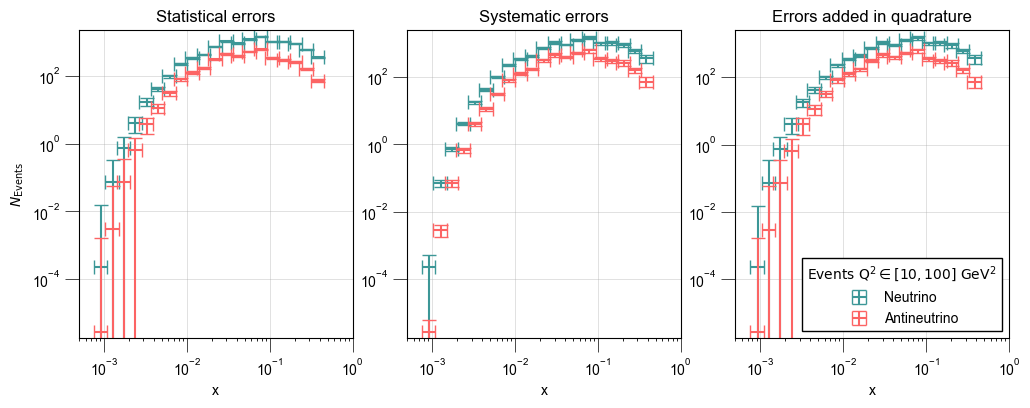

In [20]:
from aquarel import load_theme


plt.rcParams["font.family"] = "Times New Roman";plt.rcParams["font.size"] = 30

experiment = 'FASERv2';neutrino = 14
x_lower, x_upper, q2_lower,q2_upper,N_array,stat_error,sys_error = file_reader(experiment,neutrino)

#sum in certain q range
q2min = 10;q2max = 100
locs_above = np.where(q2_lower >= q2min)[0];locs_below = np.where(q2_upper <= q2max)[0];
locs = list(set(locs_above) & set(locs_below))
#sum over multiple x's

N_plot = N_array[locs];x_plot = x_lower[locs];sys_plot = sys_error[locs];stat_plot = stat_error[locs]
x_ploterr = (x_upper[locs]-x_plot)/2
#plot
FONTSIZE = 10
with load_theme("boxy_light").set_transforms(trim=True):
    fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize = (12,4))
    ax1.errorbar(x_plot,N_plot,xerr = x_ploterr,yerr = stat_plot,label = 'Neutrino',ls = 'none',capsize = 5)
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax3.set_xscale('log')
    ax3.set_yscale('log')
    ax2.errorbar(x_plot,N_plot,xerr = x_ploterr,yerr = sys_plot,label = 'Neutrino',ls = 'none',capsize = 5)
    ax3.errorbar(x_plot,N_plot,xerr = x_ploterr,yerr = np.sqrt(sys_plot**2+stat_plot**2),label = 'Neutrino',ls = 'none',capsize = 5)
    ax1.set_title('Statistical errors');ax2.set_title('Systematic errors');ax3.set_title('Errors added in quadrature')
    ax1.set_xlabel('x');ax2.set_xlabel('x');ax3.set_xlabel('x')
    ax1.set_ylabel(r'$N_{\rm Events}$')
    # ax1.text(0.7e-2,7e-2,'Events Summed from \n $Q^2\in$  [%s-%s]  GeV2' %(str(q2min),str(q2max)),fontsize = FONTSIZE)
    # ax2.text(0.7e-2,7e-2,'Events Summed from \n $Q^2\in$ [%s-%s]  GeV2' %(str(q2min),str(q2max)),fontsize = FONTSIZE)
    # ax3.text(0.7e-2,7e-2,'Events Summed from \n $Q^2\in$ [%s-%s]  GeV2' %(str(q2min),str(q2max)),fontsize = FONTSIZE)
    ax1.set_xlim(5e-4,1e0);ax2.set_xlim(5e-4,1e0);ax3.set_xlim(5e-4,1e0)
    # stringsave = '_'.join(['error_plot',experiment,str(neutrino)])+'.pdf'
    # plt.savefig(stringsave,bbox_inches='tight')

    experiment = 'FASERv2'; neutrino = -14
    x_lower, x_upper, q2_lower,q2_upper,N_array,stat_error,sys_error = file_reader(experiment,neutrino)

    #sum in certain q range
    q2min = 10;q2max = 100
    locs_above = np.where(q2_lower >= q2min)[0];locs_below = np.where(q2_upper <= q2max)[0];
    locs = list(set(locs_above) & set(locs_below))
    #sum over multiple x's

    N_plot = N_array[locs];x_plot = x_lower[locs];sys_plot = sys_error[locs];stat_plot = stat_error[locs]
    x_ploterr = (x_upper[locs]-x_plot)/2
    
    ax1.errorbar(x_plot,N_plot,xerr = x_ploterr,yerr = stat_plot,label = 'Antineutrino',ls = 'none',capsize = 5)
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax3.set_xscale('log')
    ax3.set_yscale('log')
    ax2.errorbar(x_plot,N_plot,xerr = x_ploterr,yerr = sys_plot,label = 'Antineutrino',ls = 'none',capsize = 5)
    ax3.errorbar(x_plot,N_plot,xerr = x_ploterr,yerr = np.sqrt(sys_plot**2+stat_plot**2),label = 'Antineutrino',ls = 'none',capsize = 5)
    ax1.set_title('Statistical errors');ax2.set_title('Systematic errors');ax3.set_title('Errors added in quadrature')
    ax1.set_xlabel('x');ax2.set_xlabel('x');ax3.set_xlabel('x')
    ax1.set_ylabel(r'$N_{\rm Events}$')
    # ax1.text(0.7e-2,7e-2,'Events Summed from \n $Q^2\in$  [%s-%s]  GeV2' %(str(q2min),str(q2max)),fontsize = FONTSIZE)
    # ax2.text(0.7e-2,7e-2,'Events Summed from \n $Q^2\in$ [%s-%s]  GeV2' %(str(q2min),str(q2max)),fontsize = FONTSIZE)
    # ax3.text(0.7e-2,7e-2,'Events Summed from \n $Q^2\in$ [%s-%s]  GeV2' %(str(q2min),str(q2max)),fontsize = FONTSIZE)
    ax1.set_xlim(5e-4,1e0);ax2.set_xlim(5e-4,1e0);ax3.set_xlim(5e-4,1e0)
    
    ax3.legend(title=r"$\rm{Events}~Q^2 \in [10, 100]~\rm{GeV}^2$")
   
    stringsave = '_'.join(['error_plot',experiment])+'.pdf'
    
plt.savefig(stringsave, bbox_inches='tight', dpi=350)
plt.show()

# Construct Covariance Matrix

In [31]:
#first grab data points with any file for some point
# experiment = 'FASERv';neutrino = -14;pid = neutrino
# experiment = 'FASERv2_optimistic';neutrino = 14;pid = neutrino
experiment = 'FASERv2';neutrino = 14;pid = neutrino
# experiment = 'FASERv2_nocuts';neutrino = -14;pid = neutrino
# experiment = 'FLArE10';neutrino = -14;pid = neutrino

_,_,_,_,_,stat_theta,sys_theta = file_reader(experiment,neutrino,smear_corr='theta')
_,_,_,_,_,stat_theta,sys_Ehadron = file_reader(experiment,neutrino,smear_corr='Ehadron')
_,_,_,_,_,stat_theta,sys_Elepton = file_reader(experiment,neutrino,smear_corr='Elepton')

x_lower_array, x_upper_array, q2_lower_array,q2_upper_array,N_array_array,stat_error_array,sys_error_array = file_reader(experiment,neutrino,smear_corr='')
print('Only works for 1 neutrino energy bin')

stringsave = 'clipped_nan/clipped_nan_covariance_%s_%s_charm.txt' %(experiment,MAP_FL[neutrino])
file = os.path.join(os.getcwd(),experiment,stringsave)
M_matrix = np.zeros((len(_),len(_)))

with open(file,'w') as f:
    for (ixA,xlowerA), xupperA , q2lowerA, q2upperA in zip(enumerate(x_lower_array),x_upper_array,q2_lower_array,q2_upper_array):
        for (ixB,xlowerB), xupperB , q2lowerB , q2upperB in zip(enumerate(x_lower_array),x_upper_array,q2_lower_array,q2_upper_array):
            M_A_B = sys_theta[ixA] * sys_theta[ixB] + sys_Ehadron[ixA] * sys_Ehadron[ixB] + sys_Elepton[ixA] * sys_Elepton[ixB]
#             pdb.set_trace()
#             print(M_A_B)
            line = '%s     %s     %0.2f' %(ixA,ixB,M_A_B)
            f.writelines(line + '\n')
            M_matrix[ixA,ixB] = M_A_B
            
# SAVE COVARIANCE MATRIX AS NUMPY ARRAY
np.save('%s/clipped_nan/clipped_nan_covariance_%s_%s_charm.npy' %(experiment, experiment,MAP_FL[neutrino]), M_matrix)
            
#Covariance Map
stringsave = 'covariance_%s_%s.txt' %(experiment,str(neutrino))
file = os.path.join(os.getcwd(),'CovMap.txt')
with open(file,'w') as f:
    line = '%s       %s          %s         %s          %s \n' %('A_index','xlower','xupper','Q2Lower','Q2Upper')
    f.writelines(line)
    for (ixA,xlowerA), xupperA , q2lowerA, q2upperA in zip(enumerate(x_lower_array),x_upper_array,q2_lower_array,q2_upper_array):
        line = '%0.0f             %0.5f          %0.6f         %0.4f          %0.4f \n' %(ixA,xlowerA,xupperA,q2lowerA,q2upperA)
        f.writelines(line)

Only works for 1 neutrino energy bin


# Construct no charge discrimination nu nubar covariance matrix

In [ ]:
#first grab data points with any file for some point
experiment = 'FASERv2';neutrino = 14;pid = neutrino

_,_,_,_,_,stat_theta,sys_thetanu = file_reader(experiment,neutrino,smear_corr='theta')
_,_,_,_,_,stat_theta,sys_Ehadronnu = file_reader(experiment,neutrino,smear_corr='Ehadron')
_,_,_,_,_,stat_theta,sys_Eleptonnu = file_reader(experiment,neutrino,smear_corr='Elepton')

_,_,_,_,_,stat_theta,sys_thetanubar = file_reader(experiment,-neutrino,smear_corr='theta')
_,_,_,_,_,stat_theta,sys_Ehadronnubar = file_reader(experiment,-neutrino,smear_corr='Ehadron')
_,_,_,_,_,stat_theta,sys_Eleptonnubar = file_reader(experiment,-neutrino,smear_corr='Elepton')



x_lower_array, x_upper_array, q2_lower_array,q2_upper_array,N_array_array,stat_error_array,sys_error_array = file_reader(experiment,neutrino,smear_corr='')
print('Only works for 1 neutrino energy bin')

stringsave = 'covariance_%s_+-%s.txt' %(experiment,str(neutrino))
file = os.path.join(os.getcwd(),experiment,stringsave)
M_matrix = np.zeros((len(_),len(_)))

with open(file,'w') as f:
    for (ixA,xlowerA), xupperA , q2lowerA, q2upperA in zip(enumerate(x_lower_array),x_upper_array,q2_lower_array,q2_upper_array):
        for (ixB,xlowerB), xupperB , q2lowerB , q2upperB in zip(enumerate(x_lower_array),x_upper_array,q2_lower_array,q2_upper_array):
            M_A_B = (sys_thetanu[ixA] + sys_thetanubar[ixA]) * (sys_thetanu[ixB] + sys_thetanubar[ixB]) +\
            (sys_Ehadronnu[ixA] + sys_Ehadronnubar[ixA] ) * (sys_Ehadronnu[ixB] + sys_Ehadronnubar[ixB]) + \
            (sys_Eleptonnu[ixA] + sys_Eleptonnubar[ixA]) * (sys_Eleptonnu[ixB] + sys_Eleptonnubar[ixB] )
            

            line = '%s     %s     %0.2f' %(ixA,ixB,M_A_B)
            f.writelines(line + '\n')
            M_matrix[ixA,ixB] = M_A_B

# Below here is some Debugging

In [ ]:

# fig , (ax1,ax2) = plt.subplots(1,2)
experiment = 'FASERv2'
name = os.path.join(os.getcwd(),experiment,'binned_sysevents_FASERv2_14.txt')
print(name)
N, N2d,x_edges,x_lower,x_upper,xavg,Q2_edges,q2_lower,q2_upper,qavg,diffxsec2d,xsec2d = file_reader2(name)
vmin = np.max(N2d)
print(np.sum(N2d))
a,b = plot_events(N, N2d,x_edges,x_lower,x_upper,xavg,Q2_edges,q2_lower,q2_upper,qavg,diffxsec2d,xsec2d,experiment = experiment);
N0 = np.copy(N2d)

experiment = 'FASERv2_optimistic'
name = os.path.join(os.getcwd(),experiment,'binned_sysevents_FASERv2_optimistic_14.txt')
print(name)
N, N2d,x_edges,x_lower,x_upper,xavg,Q2_edges,q2_lower,q2_upper,qavg,diffxsec2d,xsec2d = file_reader2(name)
print(np.sum(N2d))
a,b = plot_events(N, N2d,x_edges,x_lower,x_upper,xavg,Q2_edges,q2_lower,q2_upper,qavg,diffxsec2d,xsec2d,experiment = experiment);
N1 = np.copy(N2d)

plt.figure(figsize = (32,16))
plt.pcolormesh(x_edges,Q2_edges,np.transpose(N1-N0))
plt.colorbar()
plt.xscale('log');plt.yscale('log')
plotgrid(x_lower,x_upper,q2_lower,q2_upper)

# More Plottings

In [ ]:
#check for one of these bins
#select bin
# %matplotlib auto
x_bin = [0.72790 , 0.8]
# x_bin = [0.52983, 0.72790]
# x_bin = [0.04175, 0.05736]

q2_bin = [200, 250]
Enu_bin = [11.4, 5696]
neutrino = 14;pid = neutrino
N0 = 10000000

#need N = 10000000 for +-2% deviation for Faserv2, faserv2
#grab thresholds

#generate El 
EH_min,EH_max,theta_min,theta_max,El_min,El_max = thresholds('FASERv2',pid)


plt.figure(figsize = (12,12))
fig2 ,(ax3,ax4) = plt.subplots(1,2,figsize = (12,12))
fig3 ,(ax5,ax6) = plt.subplots(1,2,figsize = (12,12))
NN = 10
vanC = np.zeros(NN);vanN = np.zeros_like(vanC)
optC = np.zeros(NN);optN = np.zeros_like(optC)
m_N = 0.938
# del Q2_array
for ii in np.arange(NN):
    N = int(N0 * 10**ii)
    N = N0
    El_array = np.random.uniform(low = El_min,high = El_max,size = N);El_array_0 = np.copy(El_array)
    EH_array = np.random.uniform(low = EH_min,high = EH_max,size = N);EH_array_0 = np.copy(EH_array)
#     EH_array = np.random.uniform(low = EH_min,high = EH_max - El_array,size = N);EH_array_0 = np.copy(EH_array)
    
    theta_max_capped = np.minimum(theta_max,np.nan_to_num(2*np.arcsin(np.sqrt(2*m_N*EH_array_0 / (4*El_array_0 * (EH_array_0 + El_array_0) ))),nan=np.inf)) 
#     theta_max_capped = theta_max
    theta_array = np.random.uniform(low = theta_min,high = theta_max_capped,size = N);theta_array_0 = np.copy(theta_array)
    for experiment in ['FASERv2','FASERv2_optimistic']:

        del_theta,del_El,del_EH = delta_exp(experiment,pid)
#         del_theta,del_El,del_EH = delta_exp('FASERv2',pid)


        
        theta_array = np.random.normal(loc = theta_array_0, scale = del_theta)
        El_array = np.random.normal(loc = El_array_0,scale = del_El * El_array_0)
        EH_array = np.random.normal(loc = EH_array_0,scale = del_EH * EH_array_0)

        
        #generate x,y,Q2
        Enu_array = EH_array + El_array
        Q2_array = 4*Enu_array*El_array*np.sin(theta_array/2)**2
        x_array = Q2_array / (2 * m_N * (Enu_array - El_array))
        y_array = Q2_array / (2 * m_N * Enu_array * x_array)

        #now cut
        Enu_max = 6e3
        locs = np.where((y_array > 0 ) & (y_array < 1) & (x_array > 0) & (x_array < 1) & (Enu_array > 0) & (Enu_array < Enu_max) & (Q2_array > 4))
        Enu_cut = Enu_array[locs]
        x_cut = x_array[locs]
        Q2_cut = Q2_array[locs]

        #grab points
        
        
        
        if ii==NN - 1:
            x,q,Enu1 = N_bin_alt_sys(x_bin,Enu_bin,q2_bin,x_cut,Enu_cut,Q2_cut,pid = pid,experiment = experiment,check_points = 1)
            if experiment=='FASERv2':
                ax3.scatter(x,q,label = experiment,alpha = 0.5)
                ax3.legend(fontsize = 15);ax3.set_yscale('log');ax3.set_xscale('log')
                ax3.plot(np.mean(x),np.mean(q),'r*',markersize = 25)
                ax3.text(x_bin[0],q2_bin[0] ,'Avg Enu: %1.2f \n std Enu: %1.2f' %(np.mean(Enu1),np.std(Enu1)),fontsize = 20)
                
#                 y = q / (2 * mt * Enu1 * x) 
#                 zV = dsigmanudxdq2_interp_invgev2(x,y,q);
                qvan = q
                xvan = x
                Evan = Enu1
                ax5.scatter(x,Enu1,label = experiment);ax5.set_xlabel('x');ax5.set_ylabel('Enu');ax5.set_yscale('log');ax5.set_xscale('log')
            else:
                ax4.scatter(x,q,label=experiment,alpha = 0.5)
                ax4.legend(fontsize = 15);ax4.set_yscale('log');ax4.set_xscale('log')
                ax4.plot(np.mean(x),np.mean(q),'r*',markersize = 25)
                ax4.text(x_bin[0],q2_bin[0] ,'Avg Enu: %1.2f \n std Enu: %1.2f' %(np.mean(Enu1),np.std(Enu1)),fontsize = 20)
#                 y = q / (2 * mt * Enu1 * x) 
#                 zO = dsigmanudxdq2_interp_invgev2(x,y,q)   
                qopt = q
                xopt = x;
                Eopt = Enu1;
                ax6.scatter(x,Enu1,label = experiment);ax6.set_xlabel('x');ax6.set_ylabel('Enu');ax6.set_yscale('log');ax6.set_xscale('log')




        #calculate event rate
        N_here,acceptance,Nsamples,xavg,q2avg,Enuavg = N_bin_alt_sys(x_bin,Enu_bin,q2_bin,x_cut,Enu_cut,Q2_cut,pid = pid,experiment = experiment)
        
        if experiment == 'FASERv2':
            vanN[ii] = Nsamples
            vanC[ii] = N_here
            a,b = x_array,Q2_array
            
            
        else:
            optN[ii] = Nsamples
            optC[ii] = N_here
            c,d = x_array,Q2_array
#         print('%1.0f : %s: has event rate %1.4f with %1.4f samples' %(N , experiment,np.sum(N_here),Nsamples))


        #calculate event rate
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize = 20)
fig,(ax1,ax2) = plt.subplots(1,2,figsize = (12,12))
ax1.plot(vanN,label='vanilla samples');ax1.plot(optN,label = 'opt samples');ax1.legend(fontsize = 20);
ax2.plot(vanC,label = 'vanilla counts');ax2.plot(optC,label = 'optimistic counts');ax2.legend(fontsize = 20);
ax2.axhline(y=np.mean(vanC));ax2.axhline(y=np.mean(optC))

factor = np.mean(optN / vanN)
# ax2.plot(optC * factor,label='rescaled')
plt.figure(figsize = (12,12))
plt.plot(1-vanC / optC ,label = 'percent difference')
plt.axhline(np.mean(1-vanC / optC))
plt.legend()
if N <= 100000:
    plt.figure(figsize = (12,12))
    plt.scatter(a,b,label = 'vanilla',s = 2);plt.scatter(c,d,label = 'opt',s = 2);plt.legend(fontsize = 20)
    plt.xscale('log');plt.yscale('log')

    plt.axvline(x = x_bin[0]);plt.axvline(x = x_bin[1])
    plt.axhline(y = q2_bin[0]);plt.axhline(y = q2_bin[1])


In [ ]:
# x_bin = [0.7279, 1];q2_bin = [100,1000]
x = np.geomspace(x_bin[0],x_bin[1],30);q2 = np.geomspace(q2_bin[0],q2_bin[1],30);mt = 0.938
import matplotlib.colors as colors

Enua = 100
Enub = 500
Enuc = 2000
Enud = 4000
Enu = [Enua,Enub,Enuc,Enud]
print(x_bin)
print(q2_bin)
fig,ax = plt.subplots(2,2,figsize = (16,16));
for ii in np.arange(np.size(ax)):
    ax.flatten()[ii].set_yscale('log');ax.flatten()[ii].set_xscale('log');ax.flatten()[ii].set_ylabel('q2');ax.flatten()[ii].set_xlabel('x');
    z = np.zeros((30,30))
    for iix,xx in enumerate(x):
        for iiq,q in enumerate(q2):
            y = q/(2*mt*Enu[ii]*xx)
            if y>1:
                continue
            z[iix,iiq] = dsigmanudxdq2_interp_invgev2(xx,y,q) 
    D = ax.flatten()[ii].pcolormesh(x,q2,z.T,norm = colors.LogNorm(vmin = np.nanmin(z),vmax = np.nanmax(z)))
#     plt.colorbar(D,ax.flatten()[ii])
    ax.flatten()[ii].set_title('Enu = %1.1f' %Enu[ii])
# fig.colorbar(ax[0][0])

plt.show()

In [ ]:
%matplotlib notebook

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d    

fig = plt.figure()

ax = fig.add_subplot(projection='3d')
# ax.set_yscale('log')
# ax.set_xscale('log')
yvan = qvan/(2*mt*Evan*xvan)
ax.set_title('van')
factor = dsigmanudxdq2_interp_invgev2(xvan,yvan,qvan) 

ax.scatter(xvan,qvan,Evan,s=10)

fig = plt.figure()
# ax.set_yscale('log')
# ax.set_xscale('log')
ax = fig.add_subplot(projection='3d')
yopt = qopt/(2*mt*Eopt*xopt)

ax.set_title('opt')
factor = dsigmanudxdq2_interp_invgev2(xopt,yopt,qopt) 
s = 30*(factor/np.max(factor))**4
ax.scatter(xopt,qopt,Eopt,s=10)



In [ ]:
%matplotlib auto
plt.plot(1,1)


# Check the total cross section

In [ ]:
N = 1000000
A = 1
x_array = np.random.uniform(1e-4,1,size = N)
y_array = np.random.uniform(0,1,size = N)
E_test = 5e4
mt = 0.938*A;m_N = mt
q2_array = 2 * mt*  E_test * x_array * y_array
locs = np.where((q2_array >= 1) & (q2_array<1e6))
x_array = x_array[locs];y_array = y_array[locs]
volume = 1 * 1
invgev2_pb = 3.89e-28 * 1e36
def dsigmadxdy_enu(x,y,Enu):
    mt = 0.938*A
    s = mt**2 + 2*mt*Enu
    q2 = 2 * mt * Enu * x * y
    
    return dsigmanudxdy_interp_invgev2(x,y,q2)*4
integrand = dsigmadxdy_enu(x_array,y_array,E_test)
print('Cross section at %0.0f is %0.4f pb ' %(E_test,sum(integrand) * invgev2_pb * volume / len(locs[0])) )

def dsigmadxdq2_enu(x,Q2,Enu):
    mt = 0.938*A
    s = mt**2 + 2*mt*Enu
    y = Q2 / (2 * mt * Enu * x)    
    return dsigmanudxdq2_interp_invgev2(x,y,Q2)*4

E_test = 5e3
x_array = np.random.uniform(1e-4,1,size = N)
q2_array = np.random.uniform(1,1e6,size = N)

y = q2_array / (2 * mt * E_test * x_array)
locs = np.where((y > 0) & (y < 1));x_array = x_array[locs];q2_array = q2_array[locs];
volume = (max(x_array) - min(x_array)) * ( max(q2_array) - min(q2_array))
integrand = dsigmadxdq2_enu(x_array,q2_array,E_test)
print('Cross section at %0.0f is %0.4f pb ' %(E_test,sum(integrand) * invgev2_pb * volume / len(locs[0])) )
